[**Link here**](https://www.kaggle.com/datasets/forderation/breakhis-400x)

 **Download the dataset from Kaggle**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

os.environ['KAGGLE_USERNAME'] = "shenhav026" # username from the json file
os.environ['KAGGLE_KEY'] = "fecdd1158d18301e53d18c19ed884477" # key from the json file

In [ ]:
! kaggle datasets download -d forderation/breakhis-400x

100% 803M/803M [00:36<00:00, 24.0MB/s]
100% 803M/803M [00:36<00:00, 22.9MB/s]


In [ ]:
! mkdir dataset
! unzip breakhis-400x.zip -d dataset

Archive:  breakhis-400x.zip
  inflating: dataset/BreaKHis 400X/test/benign/SOB_B_A-14-22549AB-400-001.png  
  inflating: dataset/BreaKHis 400X/test/benign/SOB_B_A-14-22549AB-400-003.png  
  inflating: dataset/BreaKHis 400X/test/benign/SOB_B_A-14-22549AB-400-004.png  
  inflating: dataset/BreaKHis 400X/test/benign/SOB_B_A-14-22549AB-400-005.png  
  inflating: dataset/BreaKHis 400X/test/benign/SOB_B_A-14-22549AB-400-007.png  
  inflating: dataset/BreaKHis 400X/test/benign/SOB_B_A-14-22549AB-400-011.png  
  inflating: dataset/BreaKHis 400X/test/benign/SOB_B_A-14-22549AB-400-015.png  
  inflating: dataset/BreaKHis 400X/test/benign/SOB_B_A-14-22549AB-400-019.png  
  inflating: dataset/BreaKHis 400X/test/benign/SOB_B_A-14-22549AB-400-025.png  
  inflating: dataset/BreaKHis 400X/test/benign/SOB_B_A-14-22549AB-400-027.png  
  inflating: dataset/BreaKHis 400X/test/benign/SOB_B_A-14-22549AB-400-028.png  
  inflating: dataset/BreaKHis 400X/test/benign/SOB_B_A-14-22549CD-400-004.png  
  inflating:

In [ ]:
import os
import gc
import cv2
import json
import math
import scipy
import itertools
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from keras import layers
from keras.applications import ResNet50,MobileNet, DenseNet201,DenseNet121 , InceptionV3, NASNetLarge, InceptionResNetV2, NASNetMobile
from keras import layers
from keras.layers import Dense,Dropout,Activation,Add,MaxPooling2D,Conv2D,Flatten,BatchNormalization
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.optimizers import Adam
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
from tqdm import tqdm
from keras import backend as K
from functools import partial
from collections import Counter

%matplotlib inline
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
train_generator = ImageDataGenerator(
        zoom_range=2,  # set range for random zoom
        rotation_range = 90,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
)

BATCH_SIZE = 16

def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".png":
            img = read(PATH)

            img = cv2.resize(img, (RESIZE,RESIZE))

            IMG.append(np.array(img))
    return IMG

benign_train = np.array(Dataset_loader('/content/dataset/BreaKHis 400X/train/benign',224))
malign_train = np.array(Dataset_loader('/content/dataset/BreaKHis 400X/train/malignant',224))
benign_test = np.array(Dataset_loader('/content/dataset/BreaKHis 400X/test/benign',224))
malign_test = np.array(Dataset_loader('/content/dataset/BreaKHis 400X/test/malignant',224))

100%|██████████| 369/369 [00:04<00:00, 79.33it/s]


In [ ]:
# Create labels
benign_train_label = np.zeros(len(benign_train))
malign_train_label = np.ones(len(malign_train))
benign_test_label = np.zeros(len(benign_test))
malign_test_label = np.ones(len(malign_test))
label =  {0:"benign",1:"malignant"}

# Merge data
X_train = np.concatenate((benign_train, malign_train), axis = 0)
Y_train = np.concatenate((benign_train_label, malign_train_label), axis = 0)
X_test = np.concatenate((benign_test, malign_test), axis = 0)
Y_test = np.concatenate((benign_test_label, malign_test_label), axis = 0)

# Shuffle train data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

# Shuffle test data
s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

# To categorical
Y_train = to_categorical(Y_train, num_classes= 2)
Y_test = to_categorical(Y_test, num_classes= 2)

x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train,
    test_size=0.2,
    random_state=11
)

**DenseNet-121 model**

In [ ]:
def create_densenet121():
    base_model = DenseNet121(include_top=False, weights='imagenet',input_shape=(224,224,3))
    model = Sequential()
    model.add(base_model)
    model.add(Conv2D(16, (3, 3), padding="valid", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=(1, 1), padding="same"))
    model.add(Conv2D(32, (3, 3), padding="valid", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=(1, 1), padding="same"))
    model.add(Conv2D(64, (3, 3), padding="valid", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=(1, 1), padding="same"))
    model.add(Flatten())
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(2, activation='sigmoid'))

    for layer in base_model.layers:
     layer.trainable = False
    #early stop  to avoid overfitting
    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5)

    device_name = tf.test.gpu_device_name()
    if len(device_name) > 0:
      print("Found GPU at: {}".format(device_name))
    else:
      device_name = "/device:CPU:0"
      print("No GPU, using {}.".format(device_name))

    with tf.device(device_name):
       opt = tf.keras.optimizers.Adam(learning_rate=0.0005)
       model.compile(optimizer=opt,loss='binary_crossentropy', metrics=['accuracy'])
       #history = model.fit(train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),steps_per_epoch=x_train.shape[0] / BATCH_SIZE,epochs=5,validation_data=(x_val, y_val),callbacks=[es])
       #history = model.fit(x_train, y_train,validation_split=0.2,shuffle=True, epochs=5, batch_size=16,callbacks=[es])
       history1 = model.fit(x_train, y_train,validation_split=0.2,shuffle=True, epochs=50, batch_size=64)
       loss_value_test , accuracy_test = model.evaluate(X_test, Y_test)
       loss_value_train , accuracy_train = model.evaluate(x_train, y_train)


    Acc_Epochs_Plot(history1)
    print('Test_loss_train_value = ' +str(loss_value_train))
    print('test_accuracy_train = ' + str(accuracy_train))

    print('Test_loss_value = ' +str(loss_value_test))
    print('test_accuracy = ' + str(accuracy_test))
    return model


29084464/29084464 [==============================] - 2s 0us/step
Found GPU at: /device:GPU:0
Epoch 1/50
12/12 [==============================] - 23s 385ms/step - loss: 0.6626 - accuracy: 0.6485 - val_loss: 0.9610 - val_accuracy: 0.6739
Epoch 2/50
12/12 [==============================] - 1s 48ms/step - loss: 0.5999 - accuracy: 0.6962 - val_loss: 0.6584 - val_accuracy: 0.7880
Epoch 3/50
12/12 [==============================] - 1s 48ms/step - loss: 0.5358 - accuracy: 0.7534 - val_loss: 0.5700 - val_accuracy: 0.7989
Epoch 4/50
12/12 [==============================] - 1s 48ms/step - loss: 0.5056 - accuracy: 0.7807 - val_loss: 0.5008 - val_accuracy: 0.7935
Epoch 5/50
12/12 [==============================] - 1s 48ms/step - loss: 0.4782 - accuracy: 0.7943 - val_loss: 0.4742 - val_accuracy: 0.8043
Epoch 6/50
12/12 [==============================] - 1s 48ms/step - loss: 0.4540 - accuracy: 0.8134 - val_loss: 0.4666 - val_accuracy: 0.8207
Epoch 7/50
12/12 [==============================] - 1s 48ms

<ipython-input-2-a8888f54ad66>:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


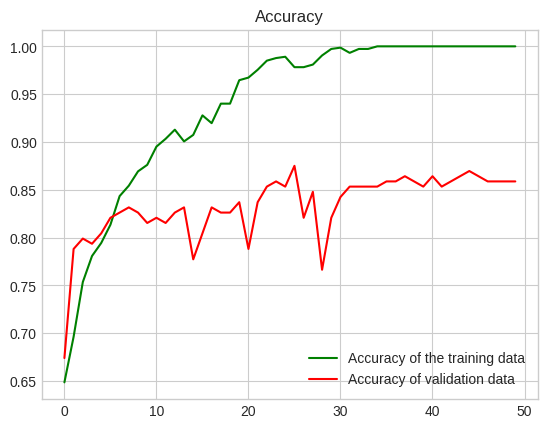

Test_loss_train_value = 0.10184988379478455
test_accuracy_train = 0.9716775417327881
Test_loss_value = 0.486363023519516
test_accuracy = 0.8458715677261353


In [ ]:
densenet_121 = create_densenet121()
densenet_121.save(filepath="/content/drive/MyDrive/Models/densenet121_hist/my_densenet_model.h5", overwrite=True, save_format=None, options=None)

18/18 [==============================] - 2s 17ms/step
Accuracy: 0.8459
Precision: 0.8800
Recall: 0.8943
F1 Score: 0.8871


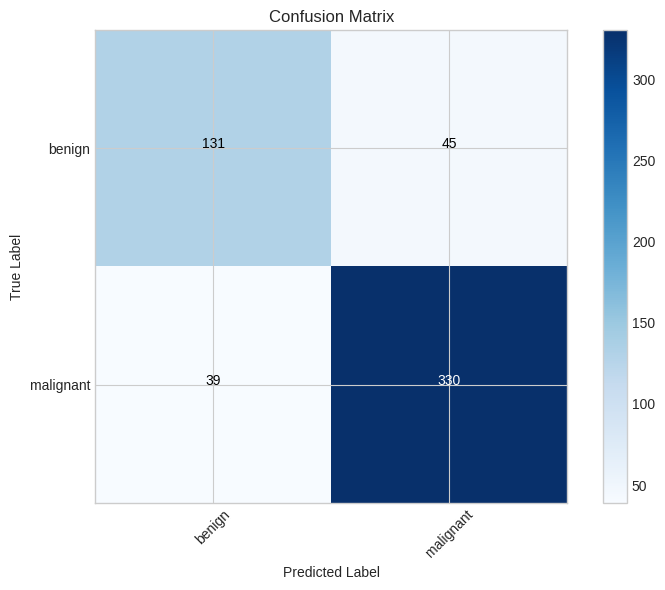

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score

predictions = densenet_121.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(Y_test, axis=1)

# Create confusion matrix
cm1 = confusion_matrix(true_labels, predicted_labels)

# Calculate performance metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

# Print performance metrics
print("Accuracy: {:.4f}".format(accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1 Score: {:.4f}".format(f1))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm1, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(label))
plt.xticks(tick_marks, label.values(), rotation=45)
plt.yticks(tick_marks, label.values())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add values to the plot
thresh = cm1.max() / 2.0
for i, j in itertools.product(range(cm1.shape[0]), range(cm1.shape[1])):
    plt.text(j, i, format(cm1[i, j], 'd'), horizontalalignment="center",
             color="white" if cm1[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

**Inception V3 Model**

In [ ]:
def create_inceptionV3():
    base_model = InceptionV3(include_top=False, weights='imagenet',input_shape=(224,224,3))
    model = Sequential()
    model.add(base_model)
    model.add(Conv2D(16, (3, 3), padding="valid", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=(1, 1), padding="same"))
    model.add(Conv2D(64, (3, 3), padding="valid", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=(1, 1), padding="same"))
    model.add(Flatten())
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(2, activation='sigmoid'))

    for layer in base_model.layers:
     layer.trainable = False
    #early stop  to avoid overfitting
    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5)

    device_name = tf.test.gpu_device_name()
    if len(device_name) > 0:
      print("Found GPU at: {}".format(device_name))
    else:
      device_name = "/device:CPU:0"
      print("No GPU, using {}.".format(device_name))

    with tf.device(device_name):
       #model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
       opt = tf.keras.optimizers.Adam(learning_rate=0.0005)
       model.compile(optimizer=opt,loss='binary_crossentropy', metrics=['accuracy'])
       #history = model.fit(train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),steps_per_epoch=x_train.shape[0] / BATCH_SIZE,epochs=5,validation_data=(x_val, y_val),callbacks=[es])
       #history = model.fit(x_train, y_train,validation_split=0.2,shuffle=True, epochs=5, batch_size=16,callbacks=[es])
       history2 = model.fit(x_train, y_train,validation_split=0.2,shuffle=True, epochs=50, batch_size=64)
       loss_value_test , accuracy_test = model.evaluate(X_test, Y_test)
       loss_value_train , accuracy_train = model.evaluate(x_train, y_train)
    Acc_Epochs_Plot(history2)
    print('Test_loss_train_value = ' +str(loss_value_train))
    print('test_accuracy_train = ' + str(accuracy_train))

    print('Test_loss_value = ' +str(loss_value_test))
    print('test_accuracy = ' + str(accuracy_test))
    return model

87910968/87910968 [==============================] - 3s 0us/step
Found GPU at: /device:GPU:0
Epoch 1/50
12/12 [==============================] - 10s 330ms/step - loss: 0.7639 - accuracy: 0.5545 - val_loss: 2.4020 - val_accuracy: 0.3370
Epoch 2/50
12/12 [==============================] - 1s 57ms/step - loss: 0.7210 - accuracy: 0.5995 - val_loss: 1.1862 - val_accuracy: 0.3804
Epoch 3/50
12/12 [==============================] - 1s 57ms/step - loss: 0.6967 - accuracy: 0.6267 - val_loss: 0.9017 - val_accuracy: 0.5000
Epoch 4/50
12/12 [==============================] - 1s 57ms/step - loss: 0.6738 - accuracy: 0.6267 - val_loss: 0.8005 - val_accuracy: 0.5109
Epoch 5/50
12/12 [==============================] - 1s 58ms/step - loss: 0.6646 - accuracy: 0.6567 - val_loss: 0.6007 - val_accuracy: 0.6902
Epoch 6/50
12/12 [==============================] - 1s 58ms/step - loss: 0.6643 - accuracy: 0.6499 - val_loss: 2.0323 - val_accuracy: 0.5163
Epoch 7/50
12/12 [==============================] - 1s 57ms

<ipython-input-11-8f56655c10c6>:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


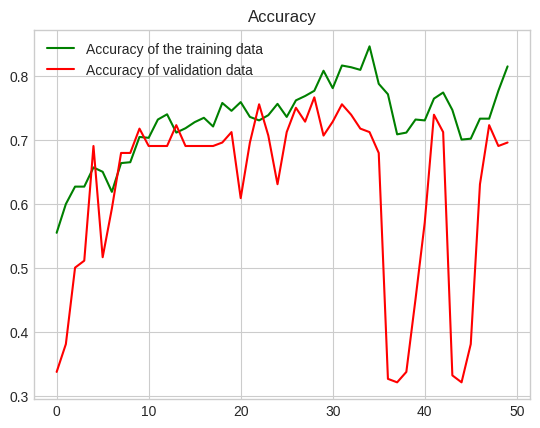

Test_loss_train_value = 0.6328635215759277
test_accuracy_train = 0.687363862991333
Test_loss_value = 0.7387272715568542
test_accuracy = 0.6807339191436768


In [ ]:
inception_v3 = create_inceptionV3()
inception_v3.save(filepath="/content/drive/MyDrive/Models/inception_hist/my_inception_model.h5", overwrite=True, save_format=None, options=None)

18/18 [==============================] - 2s 25ms/step
Accuracy: 0.6807
Precision: 0.6796
Recall: 1.0000
F1 Score: 0.8092


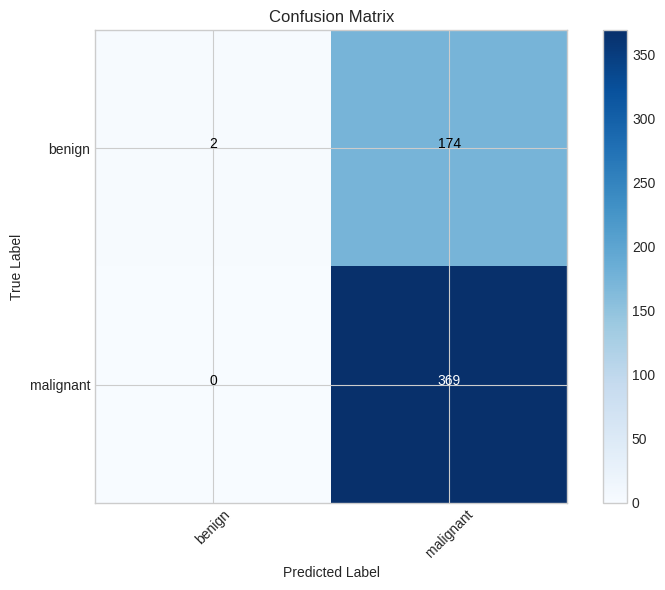

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score

predictions = inception_v3.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(Y_test, axis=1)

# Create confusion matrix
cm1 = confusion_matrix(true_labels, predicted_labels)

# Calculate performance metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

# Print performance metrics
print("Accuracy: {:.4f}".format(accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1 Score: {:.4f}".format(f1))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm1, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(label))
plt.xticks(tick_marks, label.values(), rotation=45)
plt.yticks(tick_marks, label.values())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add values to the plot
thresh = cm1.max() / 2.0
for i, j in itertools.product(range(cm1.shape[0]), range(cm1.shape[1])):
    plt.text(j, i, format(cm1[i, j], 'd'), horizontalalignment="center",
             color="white" if cm1[i, j] > thresh else "black")

plt.tight_layout()
plt.show()



#Comparting between the models

Found GPU at: /device:GPU:0
Epoch 1/50
12/12 [==============================] - 13s 454ms/step - loss: 0.6695 - accuracy: 0.6553 - val_loss: 0.8877 - val_accuracy: 0.7935
Epoch 2/50
12/12 [==============================] - 1s 75ms/step - loss: 0.4975 - accuracy: 0.7916 - val_loss: 0.8008 - val_accuracy: 0.7935
Epoch 3/50
12/12 [==============================] - 1s 76ms/step - loss: 0.4571 - accuracy: 0.8174 - val_loss: 0.8125 - val_accuracy: 0.7935
Epoch 4/50
12/12 [==============================] - 1s 75ms/step - loss: 0.4338 - accuracy: 0.8188 - val_loss: 0.7553 - val_accuracy: 0.7935
Epoch 5/50
12/12 [==============================] - 1s 75ms/step - loss: 0.4115 - accuracy: 0.8420 - val_loss: 0.6570 - val_accuracy: 0.7989
Epoch 6/50
12/12 [==============================] - 1s 75ms/step - loss: 0.3874 - accuracy: 0.8501 - val_loss: 0.5747 - val_accuracy: 0.7989
Epoch 7/50
12/12 [==============================] - 1s 75ms/step - loss: 0.3727 - accuracy: 0.8651 - val_loss: 0.5205 - val_

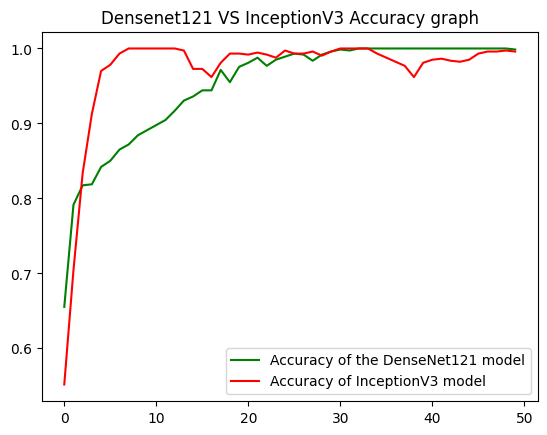

<Figure size 640x480 with 0 Axes>

In [ ]:
base_model = DenseNet121(include_top=False, weights='imagenet',input_shape=(224,224,3))
model = Sequential()
model.add(base_model)
model.add(Conv2D(16, (3, 3), padding="valid", activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2),strides=(1, 1), padding="same"))
model.add(Conv2D(32, (3, 3), padding="valid", activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2),strides=(1, 1), padding="same"))
model.add(Conv2D(64, (3, 3), padding="valid", activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2),strides=(1, 1), padding="same"))
model.add(Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(2, activation='sigmoid'))

for layer in base_model.layers:
    layer.trainable = False
    #early stop  to avoid overfitting
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5)

device_name = tf.test.gpu_device_name()
if len(device_name) > 0:
   print("Found GPU at: {}".format(device_name))
else:
   device_name = "/device:CPU:0"
   print("No GPU, using {}.".format(device_name))

with tf.device(device_name):
    opt = tf.keras.optimizers.Adam(learning_rate=0.0005)
    model.compile(optimizer=opt,loss='binary_crossentropy', metrics=['accuracy'])
    history1 = model.fit(x_train, y_train,validation_split=0.2,shuffle=True, epochs=50, batch_size=64)


base_model2 = InceptionV3(include_top=False, weights='imagenet',input_shape=(224,224,3))
model2 = Sequential()
model2.add(base_model2)
model2.add(Conv2D(16, (3, 3), padding="valid", activation="relu"))
model2.add(MaxPooling2D(pool_size=(2, 2),strides=(1, 1), padding="same"))
model2.add(Conv2D(64, (3, 3), padding="valid", activation="relu"))
model2.add(MaxPooling2D(pool_size=(2, 2),strides=(1, 1), padding="same"))
model2.add(Flatten())
model2.add(layers.Dropout(0.5))
model2.add(layers.BatchNormalization())
model2.add(layers.Dense(2, activation='sigmoid'))

for layer in base_model.layers:
    layer.trainable = False
    #early stop  to avoid overfitting
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5)

device_name = tf.test.gpu_device_name()
if len(device_name) > 0:
   print("Found GPU at: {}".format(device_name))
else:
   device_name = "/device:CPU:0"
   print("No GPU, using {}.".format(device_name))

with tf.device(device_name):
   opt = tf.keras.optimizers.Adam(learning_rate=0.0005)
   model2.compile(optimizer=opt,loss='binary_crossentropy', metrics=['accuracy'])
   history2 = model2.fit(x_train, y_train,validation_split=0.2,shuffle=True, epochs=50, batch_size=64)

Acc_DenseNet121_VS_Inception_Plot(history1,history2)


#Functions

In [ ]:
import matplotlib.pyplot as plt

def Acc_Epochs_Plot(hist):
    get_acc_train = hist.history['accuracy']
    get_acc_val = hist.history['val_accuracy']
    epochs = range(len(get_acc_train))

    # Set the style and background color
    plt.style.use('seaborn-whitegrid')
    plt.rcParams['figure.facecolor'] = 'white'

    # Plot the accuracy curves
    plt.plot(epochs, get_acc_train, 'g', label='Accuracy of the training data')
    plt.plot(epochs, get_acc_val, 'r', label='Accuracy of validation data')

    # Set plot title and legend
    plt.title('Accuracy')
    plt.legend(loc=0)

    # Show the plot
    plt.show()



In [ ]:
def Acc_DenseNet121_VS_Inception_Plot(hist1,hist2):
  get_acc_densnet = hist1.history['accuracy']
  get_acc_inception = hist2.history['accuracy']
  epochs = range(len(get_acc_densnet))
  plt.plot(epochs, get_acc_densnet, 'g' , label = 'Accuracy of the DenseNet121 model')
  plt.plot(epochs, get_acc_inception, 'r', label = 'Accuracy of InceptionV3 model')
  plt.title('Densenet121 VS InceptionV3 Accuracy graph')
  plt.legend(loc=0)
  plt.figure()
  plt.show()